# Part 4

## Correct batch effect

Scgen batch correction.

- **INPUT:**
    -  ```counts_norm.mtx``` 
    -  ```anno_cells_norm.txt``` 
    -  ```anno_samples_norm.txt``` 
    -  ```anno_genes_norm.txt``` 
    -  ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **OUTPUT:**

    -  ```counts_corr.csv.gz``` 
    -  ```anno_cells_corr.txt``` 
    -  ```anno_samples_corr.txt``` 
    -  ```anno_genes_corr.txt``` 
    -  ```adata_afterCorrection.h5ad```

### load data

In [1]:
import numpy as np
import anndata as ad
# import scgen
import scanpy as sc
import pandas as pd
import numba as nb
import scvi

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/flax/

In [2]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


In [3]:
path_to_additional_files = "../../../data/data_preprocessing/vanGalen_Hourigan/additional_input_files/"
path_in = "../../../results/data_preprocessing/vanGalen_Hourigan/normalized/"
path_out = "../../../results/data_preprocessing/vanGalen_Hourigan/batch_corrected/"

In [4]:
# read in count table and create an adata object
adata_beforeCorrection = sc.read_mtx(path_in + "counts_norm.mtx",'float64').T

In [5]:
# read in cell annotation file
anno_cells = pd.read_csv(path_in + "anno_cells_norm.txt", sep = "\t") 

In [6]:
# read in sample annotation file
anno_samples = pd.read_csv(path_in + "anno_samples_norm.txt", sep = "\t") 

In [7]:
# read in gene annotation file
anno_genes = pd.read_csv(path_in + "anno_genes_norm.txt", sep = "\t") 

In [8]:
# load cell subtype and color keys
cell_relabel=pd.read_csv(path_to_additional_files + "cell_relabelling.csv"
                        ,sep=';')

### process data

In [9]:
adata_beforeCorrection.var_names=anno_genes['gene_symbol']
print("adata_beforeCorrection.var_names[1:10]")
print(adata_beforeCorrection.var_names[1:10])
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)

adata_beforeCorrection.var_names[1:10]
Index(['A1BG-AS1', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAED1',
       'AAGAB', 'AAK1'],
      dtype='object', name='gene_symbol')


In [10]:
adata_beforeCorrection.obs_names=anno_cells['cell_ID']
print("adata_beforeCorrection.obs_names[1:10]")
print(adata_beforeCorrection.obs_names[1:10])
adata_beforeCorrection.obs = anno_cells
adata_beforeCorrection.obs.index = adata_beforeCorrection.obs.index.astype(str)

adata_beforeCorrection.obs_names[1:10]
Index(['AML1012-D0_AAAACACCAATC', 'AML1012-D0_AAAATAGCCTTT',
       'AML1012-D0_AAACATTAAACG', 'AML1012-D0_AAACCACGTGCN',
       'AML1012-D0_AAACGCTGGAAN', 'AML1012-D0_AAACTGGTACTA',
       'AML1012-D0_AAACTTGCCCGT', 'AML1012-D0_AAATGAAAGTCC',
       'AML1012-D0_AAATGTACGGTA'],
      dtype='object', name='cell_ID')


### prepare for the visualization

In [11]:
# define colors
colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color_hex"]))
print(colors_cell_type)

{'B': '#4FC384', 'Mono': '#F09040', 'T': '#4F92EE', 'DC': '#854701', 'Ery': '#F72E3A', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'HSPC': '#D040F0'}


In [12]:
#there is an error at line 9, cell_subtype is only 2 values?
adata_beforeCorrection.obs["cell_subtype"].value_counts()

cell_subtype
CD4_T        24362
CD8_T        13491
Mono         10502
HSPC          7608
B             5773
cDC           3146
pro_Mono      3056
early_Ery     2596
late_Ery      2377
Plasma         889
pDC            783
Name: count, dtype: int64

In [13]:
# add cell_subtype column
cell_subtype = []
for t in adata_beforeCorrection.obs["cell_type_original"]:
    idx=cell_relabel["cell_type_original"]==t
    cell_subtype.append(cell_relabel["cell_subtype"][idx].values[0]) #
adata_beforeCorrection.obs["cell_subtype"] = pd.DataFrame(cell_subtype).values
# re-order such that the cell subtypes apper in the correct order in the legend
adata_beforeCorrection.obs["cell_subtype"]=adata_beforeCorrection.obs["cell_subtype"].astype("category")
adata_beforeCorrection.obs['cell_subtype'].cat.reorder_categories(['HSPC'
                                                  ,'early_Ery'
                                                  ,'late_Ery'
                                                  ,'pro_Mono'
                                                  ,'Mono'
                                                  ,'cDC'
                                                  ,'pDC'
                                                  ,'B'
                                                  ,'Plasma'
                                                  ,'CD4_T'
                                                  ,'CD8_T'], inplace=True)

ValueError: 2

In [14]:
adata_beforeCorrection.obs["cell_subtype"]=adata_beforeCorrection.obs["cell_subtype"].astype("category")
adata_beforeCorrection.obs["cell_subtype"]=adata_beforeCorrection.obs['cell_subtype'].cat.reorder_categories(['HSPC'
                                                  ,'early_Ery'
                                                  ,'late_Ery'
                                                  ,'pro_Mono'
                                                  ,'Mono'
                                                  ,'cDC'
                                                  ,'pDC'
                                                  ,'B'
                                                  ,'Plasma'
                                                  ,'CD4_T'
                                                  ,'CD8_T'])

In [15]:
# rename "malignangt" columns into "bares_mutatoin"
adata_beforeCorrection.obs["bares_mutation"] = adata_beforeCorrection.obs["malignant"].astype('str')

In [16]:
# define color schemes
colors_cell_subtype=dict(zip(cell_relabel["cell_subtype"],cell_relabel["cell_subtype_color_hex"]))
print(colors_cell_subtype)

colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color_hex"]))
print(colors_cell_type)

{'B': '#4FC384', 'Mono': '#F09040', 'pro_Mono': '#F0AD40', 'CD4_T': '#4FCCEE', 'CD8_T': '#4F92EE', 'pDC': '#854701', 'cDC': '#B95D10', 'early_Ery': '#F72E3A', 'late_Ery': '#C72D37', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'Plasma': '#317E54', 'HSPC': '#D040F0'}
{'B': '#4FC384', 'Mono': '#F09040', 'T': '#4F92EE', 'DC': '#854701', 'Ery': '#F72E3A', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'HSPC': '#D040F0'}


In [17]:
adata_beforeCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for AML
                                                     , "#7ac5cd" # CadetBlue3 for healthy
                                                     ]

adata_beforeCorrection.uns["bares_mutation_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

In [18]:
print("save adata_beforeCorrection.h5ad")
adata_beforeCorrection.write(filename='adata_beforeCorrection.h5ad')

save adata_beforeCorrection.h5ad


### visualize before batch correction

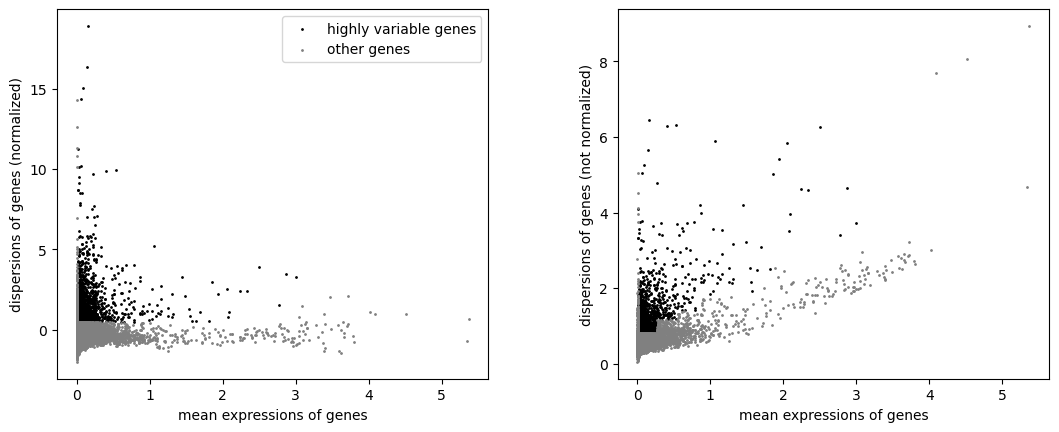

In [19]:
# logtransform before HVG calculation
sc.pp.log1p(adata_beforeCorrection)

sc.pp.highly_variable_genes(adata_beforeCorrection)
sc.pl.highly_variable_genes(adata_beforeCorrection)

In [20]:
# print how many HVGs we have:
print("Nr of HVGs:")
print(sum(adata_beforeCorrection.var.highly_variable))

Nr of HVGs:
1823


In [21]:
sc.tl.pca(adata_beforeCorrection, svd_solver='arpack')

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


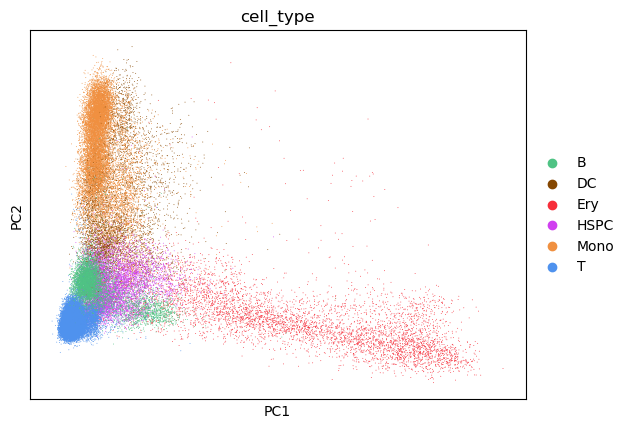

In [22]:
sc.pl.pca(adata_beforeCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
         )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


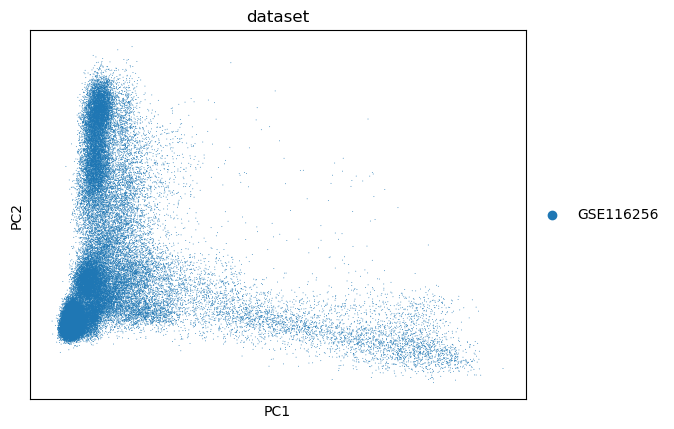

In [23]:
sc.pl.pca(adata_beforeCorrection
          , color=["dataset"]
          ,save="_beforeCorrection_cell_type_dataset.pdf"
         )

In [ ]:
adata_beforeCorrection

In [27]:
sc.pp.neighbors(adata_beforeCorrection)

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/work/project/ladcol

In [28]:
sc.tl.umap(adata_beforeCorrection)

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


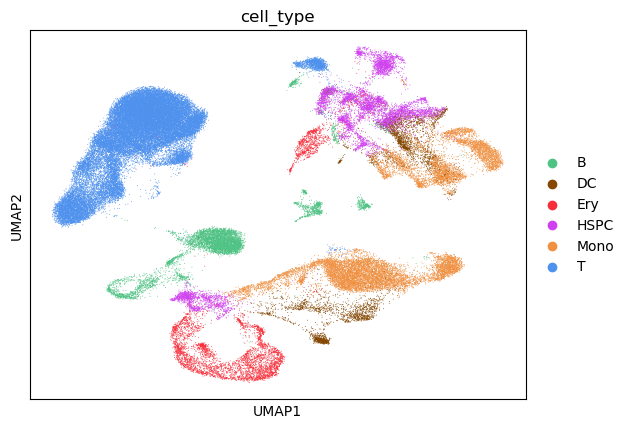

In [29]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


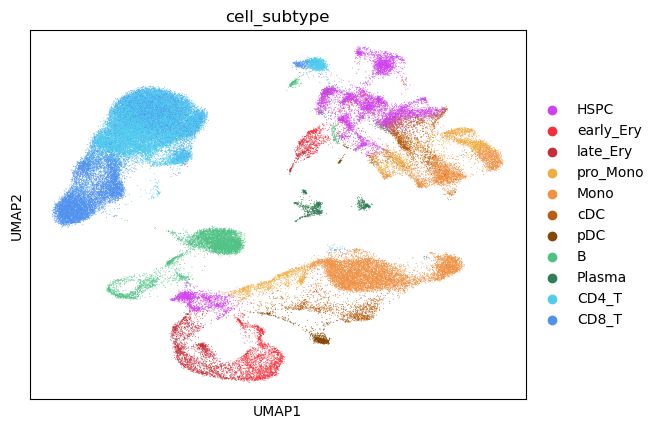

In [30]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_subtype"]
          ,palette=colors_cell_subtype
          ,save="_beforeCorrection_cell_subtype.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


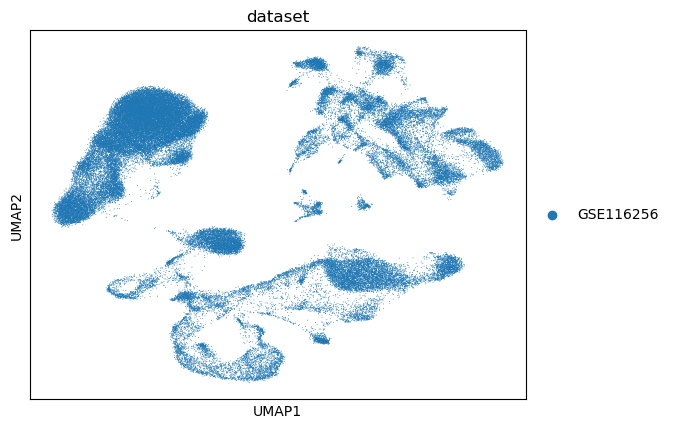

In [31]:
sc.pl.umap(adata_beforeCorrection
           , color=["dataset"]
          ,save="_beforeCorrection_dataset.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


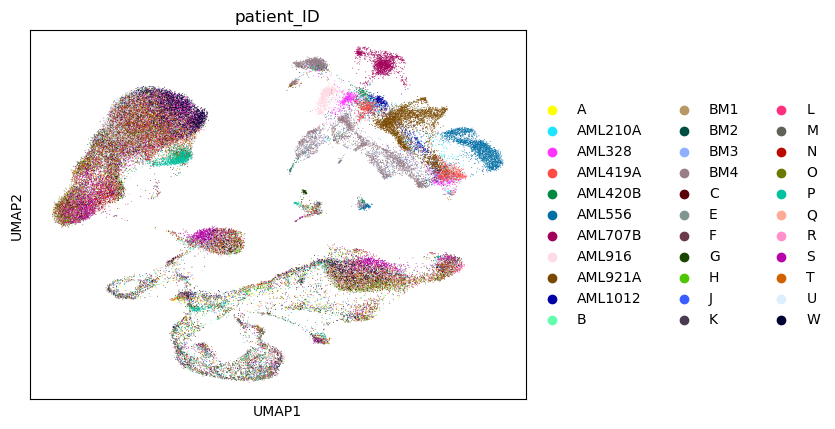

In [32]:
sc.pl.umap(adata_beforeCorrection
           , color=["patient_ID"]
          ,save="_beforeCorrection_patient_ID.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


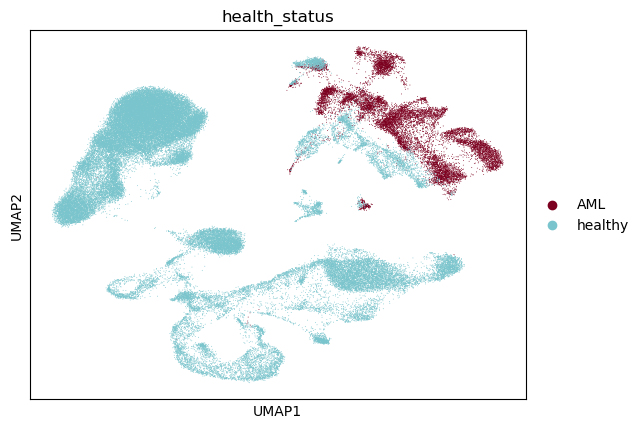

In [33]:
sc.pl.umap(adata_beforeCorrection
           , color=["health_status"]
          ,save="_beforeCorrection_health_status.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


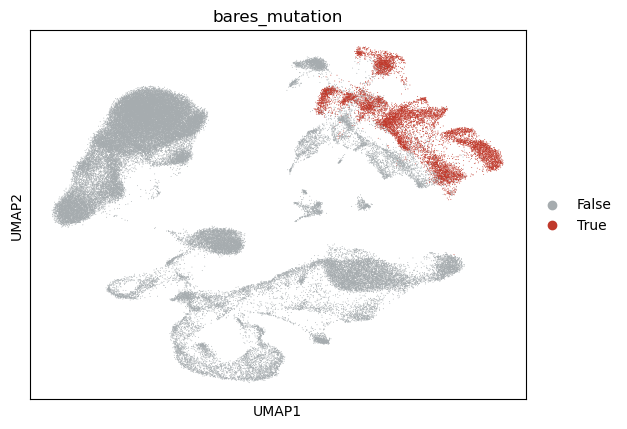

In [34]:
sc.pl.umap(adata_beforeCorrection
           , color=["bares_mutation"]
          ,save="_beforeCorrection_malignant.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


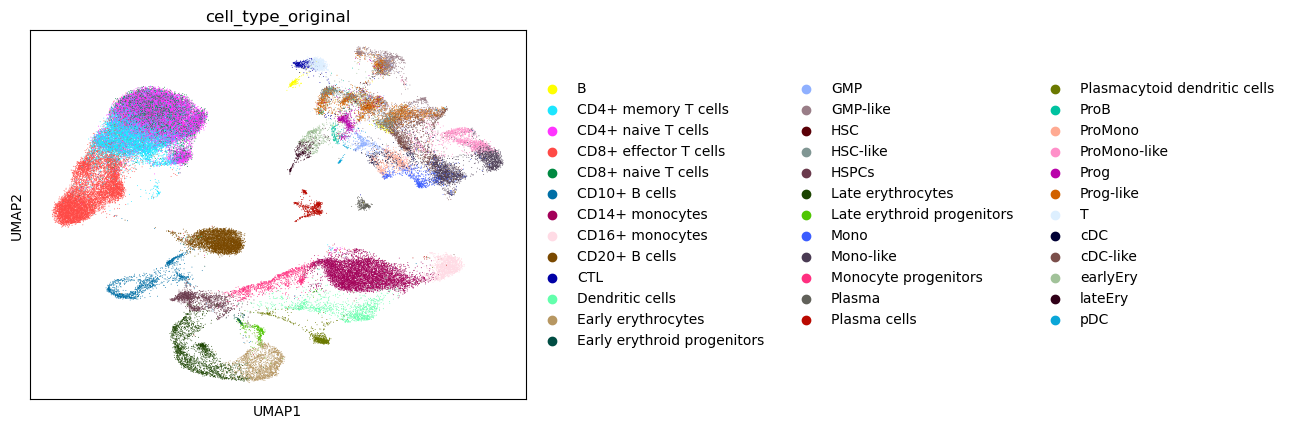

In [35]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type_original"]
          ,save="_beforeCorrection_cell_type_original.pdf"
          )

In [40]:
adata_beforeCorrection.layers

Layers with keys: 

In [ ]:
scvi.model.SCVI

In [52]:
scvi.model.SCVI.setup_anndata(adata_beforeCorrection, labels_key="cell_type", batch_key="dataset")

In [63]:
vae = scvi.model.SCVI(adata_beforeCorrection, n_layers=2, n_latent=12485, gene_likelihood="nb")

In [64]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 107/107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [09:49<00:00,  5.49s/it, v_num=1, train_loss_step=2.43e+3, train_loss_epoch=2.37e+3]

`Trainer.fit` stopped: `max_epochs=107` reached.


Epoch 107/107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [09:49<00:00,  5.51s/it, v_num=1, train_loss_step=2.43e+3, train_loss_epoch=2.37e+3]


In [65]:
# train model
vae.train(max_epochs=100,
            batch_size=32,
            early_stopping=True,
            early_stopping_patience=3,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 64/100:  64%|███████████████████████████████████████████████████████████████▎                                   | 64/100 [17:22<09:46, 16.30s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.37e+3]
Monitored metric elbo_validation did not improve in the last 3 records. Best score: 2396.227. Signaling Trainer to stop.


In [66]:
adata_afterCorrection = adata_beforeCorrection

In [67]:
adata_beforeCorrection.X

<74583x12485 sparse matrix of type '<class 'numpy.float64'>'
	with 82419567 stored elements in Compressed Sparse Row format>

In [68]:
adata_afterCorrection.X = vae.get_latent_representation()

In [69]:
adata_afterCorrection.X

array([[-8.03030953e-02,  4.91772145e-02, -1.11105330e-01, ...,
        -1.11415766e-01, -8.42608288e-02,  2.32083052e-02],
       [ 1.99031122e-02,  1.68742165e-01, -2.18261957e-01, ...,
        -7.34740198e-02, -3.25648859e-02,  1.11422136e-01],
       [-1.19764082e-01, -1.77741289e-01, -2.35282928e-01, ...,
         2.35093981e-02, -1.39279366e-02,  8.55994970e-02],
       ...,
       [-1.18264250e-01,  1.79766864e-02, -9.57087800e-02, ...,
         6.92856461e-02,  4.63898256e-02, -8.62864256e-02],
       [-1.12325922e-02, -6.93118721e-02,  8.35305005e-02, ...,
         3.30481157e-02,  2.50776801e-02,  3.79228294e-02],
       [ 8.62502083e-02,  7.22706318e-05,  1.54525250e-01, ...,
        -4.89148311e-02, -3.57659161e-02,  8.58727843e-02]], dtype=float32)

### batch correction

In [44]:
# preprocess for batch correction
scgen.SCGEN.setup_anndata(adata_beforeCorrection, batch_key="dataset", labels_key="cell_type")

In [48]:
# t=scgen.SCGEN.setup_anndata(adata_beforeCorrection, batch_key="dataset", labels_key="cell_type")

In [45]:
# create model
network = scgen.SCGEN(adata_beforeCorrection)

In [46]:
# train model
network.train(max_epochs=100,
            batch_size=32,
            early_stopping=True,
            early_stopping_patience=3,
)


Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 4/100:   4%|█████▌                                                                                                                                    | 4/100 [58:34<23:25:56, 878.71s/it, loss=289, v_num=1]
Monitored metric elbo_validation did not improve in the last 3 records. Best score: 1364.404. Signaling Trainer to stop.


In [49]:
adata_afterCorrection = network.batch_removal(t)

TypeError: concatenate() missing 1 required positional argument: 'self'

In [56]:
network.adata.concatenate(batch_key="concat_batch", index_unique=None)

AnnData object with n_obs × n_vars = 74583 × 12485
    obs: 'cell_ID', 'cell_type_original', 'sample_ID', 'malignant', 'patient_ID', 'dataset', 'gender', 'age', 'health_status', 'case_or_control', 'day', 'cell_type', 'cell_subtype', 'cell_type_original_datasetName', 'total_counts_raw', 'mito_counts', 'frac_mito', 'nr_genes', 'counts_upper_threshold', 'counts_lower_threshold', 'genes_lower_threshold', 'counts_vs_genes_threshold', 'counts_upper_filter', 'counts_lower_filter', 'genes_lower_filter', 'counts_vs_genes_filter', 'cell_filter', 'threshold_celltype_size', 'celltype_size_cf', 'celltype_size_filter', 'cell_type_ID', 'total_counts_raw_cf_ctf_gf', 'total_counts_raw_cf_ctf_gf_sf', 'sizeFactor', 'bares_mutation', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'is_in_LR_database', 'isLigand', 'isReceptor', 'sum_pseudobulkCellType_expr', 'sum_pseudobulkCellType_expr_threshold', 'sum_pseudobulkCellType_expr_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
   

In [54]:
network.adata.X

<74583x12485 sparse matrix of type '<class 'numpy.float64'>'
	with 82419567 stored elements in Compressed Sparse Row format>

In [47]:
# remove batch effect
adata_afterCorrection =  network.batch_removal()

TypeError: concatenate() missing 1 required positional argument: 'self'

In [61]:
network.batch_removal()

TypeError: concatenate() missing 1 required positional argument: 'self'

In [71]:
# restore annotations
adata_afterCorrection.var = anno_genes
adata_afterCorrection.var.index = adata_afterCorrection.var.index.astype(str)
adata_afterCorrection.var_names=anno_genes['gene_symbol']
print("adata_afterCorrection.var_names[1:10]")
print(adata_afterCorrection.var_names[1:10])

adata_afterCorrection.var_names[1:10]
Index(['A1BG-AS1', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAED1',
       'AAGAB', 'AAK1'],
      dtype='object', name='gene_symbol')


In [72]:
adata_afterCorrection.obs = anno_cells
adata_afterCorrection.obs.index = adata_afterCorrection.obs.index.astype(str)
adata_afterCorrection.obs_names=anno_cells['cell_ID']
print("adata_afterCorrection.obs_names[1:10]")
print(adata_afterCorrection.obs_names[1:10])

adata_afterCorrection.obs_names[1:10]
Index(['AML1012-D0_AAAACACCAATC', 'AML1012-D0_AAAATAGCCTTT',
       'AML1012-D0_AAACATTAAACG', 'AML1012-D0_AAACCACGTGCN',
       'AML1012-D0_AAACGCTGGAAN', 'AML1012-D0_AAACTGGTACTA',
       'AML1012-D0_AAACTTGCCCGT', 'AML1012-D0_AAATGAAAGTCC',
       'AML1012-D0_AAATGTACGGTA'],
      dtype='object', name='cell_ID')


In [73]:
print("adata_afterCorrection")
print(adata_afterCorrection)

adata_afterCorrection
AnnData object with n_obs × n_vars = 74583 × 12485
    obs: 'cell_ID', 'cell_type_original', 'sample_ID', 'malignant', 'patient_ID', 'dataset', 'gender', 'age', 'health_status', 'case_or_control', 'day', 'cell_type', 'cell_subtype', 'cell_type_original_datasetName', 'total_counts_raw', 'mito_counts', 'frac_mito', 'nr_genes', 'counts_upper_threshold', 'counts_lower_threshold', 'genes_lower_threshold', 'counts_vs_genes_threshold', 'counts_upper_filter', 'counts_lower_filter', 'genes_lower_filter', 'counts_vs_genes_filter', 'cell_filter', 'threshold_celltype_size', 'celltype_size_cf', 'celltype_size_filter', 'cell_type_ID', 'total_counts_raw_cf_ctf_gf', 'total_counts_raw_cf_ctf_gf_sf', 'sizeFactor', 'bares_mutation', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'is_in_LR_database', 'isLigand', 'isReceptor', 'sum_pseudobulkCellType_expr', 'sum_pseudobulkCellType_expr_threshold', 'sum_pseudobulkCellType_expr_filter', 'highly_variable', 'means', 'dispersions', 

### visualize after batch correction

In [ ]:
sc.pp.highly_variable_genes(adata_afterCorrection)
sc.pl.highly_variable_genes(adata_afterCorrection)

In [ ]:
print("Nr of HVGs:")
print(sum(adata_afterCorrection.var.highly_variable))

In [ ]:
sc.tl.pca(adata_afterCorrection, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata_afterCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_afterCorrection_cell_type.pdf"
         )

In [ ]:
sc.pl.pca(adata_afterCorrection
          , color=["dataset"]
          ,save="_afterCorrection_cell_type_dataset.pdf"
         )

In [ ]:
sc.pp.neighbors(adata_afterCorrection)

In [ ]:
sc.tl.umap(adata_afterCorrection)

In [ ]:
adata_afterCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for AML
                                                     , "#7ac5cd" # CadetBlue3 for healthy
                                                     ]

In [ ]:
adata_afterCorrection.uns["bares_mutation_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_afterCorrection_cell_type.pdf"
          )

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["cell_subtype"]
          ,palette=colors_cell_subtype
          ,save="_afterCorrection_cell_subtype.pdf"
          )

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["dataset"]
          ,save="_afterCorrection_dataset.pdf"
          )

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["patient_ID"]
          ,save="_afterCorrection_patient_ID.pdf"
          )

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["health_status"]
          ,save="_afterCorrection_health_status.pdf"
          )

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["bares_mutation"]
          ,save="_afterCorrection_malignant.pdf"
          )

In [ ]:
sc.pl.umap(adata_afterCorrection
           , color=["cell_type_original"]
          ,save="_afterCorrection_cell_type_original.pdf"
          )

# Export

In [53]:
# export counts as csv.gz
print("save counts_corr.csv.gz")

counts_corr=pd.DataFrame(adata_afterCorrection.X
                        ,columns=adata_afterCorrection.var_names 
                        ,index=adata_afterCorrection.obs_names
                        ).transpose()
counts_corr.to_csv(path_out + "counts_corr.csv.gz"
                   ,index=True
                   ,compression="gzip"
                   )

save counts_corr.csv.gz


In [54]:
# export anno_cells_corr
print("save anno_cells_corr.txt")
adata_afterCorrection.obs.to_csv(path_out + "anno_cells_corr.txt"
                    ,sep = "\t"
                    ,index = True)


save anno_cells_corr.txt


In [55]:
# export anno_samples_corr
print("save anno_samples_corr.txt")
anno_samples.to_csv(path_out + "anno_samples_corr.txt"
                    ,sep = "\t"
                    ,index = True)

save anno_samples_corr.txt


In [56]:
# export anno_genes_corr
print("save anno_genes_corr.txt")
adata_afterCorrection.var.to_csv(path_out + "anno_genes_corr.txt"
                    ,sep = "\t"
                    ,index = True)

save anno_genes_corr.txt


In [57]:
# export adata object
print("save adata_afterCorrection.h5ad")
adata_afterCorrection.write(path_out + "adata_afterCorrection.h5ad")

save adata_afterCorrection.h5ad


In [58]:
pwd

'/work/project/ladcol_011/polish/community-paper/src/data_preprocessing/vanGalen_Hourigan'

In [78]:
from typing import Optional, Sequence

import numpy as np
import pandas as pd
import scanpy as sc
import torch
from adjustText import adjust_text
from anndata import AnnData, concat
from matplotlib import pyplot
from scipy import stats
from scvi import REGISTRY_KEYS
from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.model.base import BaseModelClass, UnsupervisedTrainingMixin, VAEMixin
from scvi.utils import setup_anndata_dsp

# from ._scgenvae import SCGENVAE
# from ._utils import balancer, extractor

font = {"family": "Arial", "size": 14}


class SCGEN(VAEMixin, UnsupervisedTrainingMixin, BaseModelClass):
    """
    Implementation of scGen model for batch removal and perturbation prediction.

    Parameters
    ----------
    adata
        AnnData object that has been registered via :meth:`~scgen.SCGEN.setup_anndata`.
    n_hidden
        Number of nodes per hidden layer.
    n_latent
        Dimensionality of the latent space.
    n_layers
        Number of hidden layers used for encoder and decoder NNs.
    dropout_rate
        Dropout rate for neural networks.
    **model_kwargs
        Keyword args for :class:`~scgen.SCGENVAE`

    Examples
    --------
    >>> vae = scgen.SCGEN(adata)
    >>> vae.train()
    >>> adata.obsm["X_scgen"] = vae.get_latent_representation()
    """

    def __init__(
        self,
        adata: AnnData,
        n_hidden: int = 800,
        n_latent: int = 100,
        n_layers: int = 2,
        dropout_rate: float = 0.2,
        **model_kwargs,
    ):
        super(SCGEN, self).__init__(adata)

        self.module = SCGENVAE(
            n_input=self.summary_stats.n_vars,
            n_hidden=n_hidden,
            n_latent=n_latent,
            n_layers=n_layers,
            dropout_rate=dropout_rate,
            **model_kwargs,
        )
        self._model_summary_string = (
            "SCGEN Model with the following params: \nn_hidden: {}, n_latent: {}, n_layers: {}, dropout_rate: "
            "{}"
        ).format(
            n_hidden,
            n_latent,
            n_layers,
            dropout_rate,
        )
        self.init_params_ = self._get_init_params(locals())

    def predict(
        self,
        ctrl_key=None,
        stim_key=None,
        adata_to_predict=None,
        celltype_to_predict=None,
        restrict_arithmetic_to="all",
    ) -> AnnData:
        """
        Predicts the cell type provided by the user in stimulated condition.

        Parameters
        ----------
        ctrl_key: basestring
            key for `control` part of the `data` found in `condition_key`.
        stim_key: basestring
            key for `stimulated` part of the `data` found in `condition_key`.
        adata_to_predict: `~anndata.AnnData`
            Adata for unperturbed cells you want to be predicted.
        celltype_to_predict: basestring
            The cell type you want to be predicted.
        restrict_arithmetic_to: basestring or dict
            Dictionary of celltypes you want to be observed for prediction.
        Returns
        -------
        predicted_cells: np nd-array
            `np nd-array` of predicted cells in primary space.
        delta: float
            Difference between stimulated and control cells in latent space
        """
        # use keys registered from `setup_anndata()`
        cell_type_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.LABELS_KEY
        ).original_key
        condition_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.BATCH_KEY
        ).original_key

        if restrict_arithmetic_to == "all":
            ctrl_x = self.adata[self.adata.obs[condition_key] == ctrl_key, :]
            stim_x = self.adata[self.adata.obs[condition_key] == stim_key, :]
            ctrl_x = balancer(ctrl_x, cell_type_key)
            stim_x = balancer(stim_x, cell_type_key)
        else:
            key = list(restrict_arithmetic_to.keys())[0]
            values = restrict_arithmetic_to[key]
            subset = self.adata[self.adata.obs[key].isin(values)]
            ctrl_x = subset[subset.obs[condition_key] == ctrl_key, :]
            stim_x = subset[subset.obs[condition_key] == stim_key, :]
            if len(values) > 1:
                ctrl_x = balancer(ctrl_x, cell_type_key)
                stim_x = balancer(stim_x, cell_type_key)
        if celltype_to_predict is not None and adata_to_predict is not None:
            raise Exception("Please provide either a cell type or adata not both!")
        if celltype_to_predict is None and adata_to_predict is None:
            raise Exception(
                "Please provide a cell type name or adata for your unperturbed cells"
            )
        if celltype_to_predict is not None:
            ctrl_pred = extractor(
                self.adata,
                celltype_to_predict,
                condition_key,
                cell_type_key,
                ctrl_key,
                stim_key,
            )[1]
        else:
            ctrl_pred = adata_to_predict

        eq = min(ctrl_x.X.shape[0], stim_x.X.shape[0])
        cd_ind = np.random.choice(range(ctrl_x.shape[0]), size=eq, replace=False)
        stim_ind = np.random.choice(range(stim_x.shape[0]), size=eq, replace=False)
        ctrl_adata = ctrl_x[cd_ind, :]
        stim_adata = stim_x[stim_ind, :]

        latent_ctrl = self._avg_vector(ctrl_adata)
        latent_stim = self._avg_vector(stim_adata)

        delta = latent_stim - latent_ctrl

        latent_cd = self.get_latent_representation(ctrl_pred)

        stim_pred = delta + latent_cd
        predicted_cells = (
            self.module.generative(torch.Tensor(stim_pred))["px"].cpu().detach().numpy()
        )

        predicted_adata = AnnData(
            X=predicted_cells,
            obs=ctrl_pred.obs.copy(),
            var=ctrl_pred.var.copy(),
            obsm=ctrl_pred.obsm.copy(),
        )
        return predicted_adata, delta

    def _avg_vector(self, adata):
        return np.mean(self.get_latent_representation(adata), axis=0)

    @torch.no_grad()
    def get_decoded_expression(
        self,
        adata: Optional[AnnData] = None,
        indices: Optional[Sequence[int]] = None,
        batch_size: Optional[int] = None,
    ) -> np.ndarray:
        """Get decoded expression."""
        if self.is_trained_ is False:
            raise RuntimeError("Please train the model first.")

        adata = self._validate_anndata(adata)
        scdl = self._make_data_loader(
            adata=adata, indices=indices, batch_size=batch_size
        )
        decoded = []
        for tensors in scdl:
            _, generative_outputs = self.module(tensors, compute_loss=False)
            px = generative_outputs["px"].cpu()
            decoded.append(px)

        return torch.cat(decoded).numpy()

    @torch.no_grad()
    def batch_removal(self, adata: Optional[AnnData] = None) -> AnnData:
        """
        Removes batch effects.

        Parameters
        ----------
        adata
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
            corresponding to batch and cell type metadata, respectively.

        Returns
        -------
        corrected: `~anndata.AnnData`
            AnnData of corrected gene expression in adata.X and corrected latent space in adata.obsm["latent"].
            A reference to the original AnnData is in `corrected.raw` if the input adata had no `raw` attribute.
        """
        adata = self._validate_anndata(adata)
        latent_all = self.get_latent_representation(adata)
        # use keys registered from `setup_anndata()`
        cell_label_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.LABELS_KEY
        ).original_key
        batch_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.BATCH_KEY
        ).original_key

        adata_latent = AnnData(latent_all)
        adata_latent.obs = adata.obs.copy(deep=True)
        unique_cell_types = np.unique(adata_latent.obs[cell_label_key])
        shared_ct = []
        not_shared_ct = []
        for cell_type in unique_cell_types:
            temp_cell = adata_latent[
                adata_latent.obs[cell_label_key] == cell_type
            ].copy()
            if len(np.unique(temp_cell.obs[batch_key])) < 2:
                cell_type_ann = adata_latent[
                    adata_latent.obs[cell_label_key] == cell_type
                ]
                not_shared_ct.append(cell_type_ann)
                continue
            temp_cell = adata_latent[
                adata_latent.obs[cell_label_key] == cell_type
            ].copy()
            batch_list = {}
            batch_ind = {}
            max_batch = 0
            max_batch_ind = ""
            batches = np.unique(temp_cell.obs[batch_key])
            for i in batches:
                temp = temp_cell[temp_cell.obs[batch_key] == i]
                temp_ind = temp_cell.obs[batch_key] == i
                if max_batch < len(temp):
                    max_batch = len(temp)
                    max_batch_ind = i
                batch_list[i] = temp
                batch_ind[i] = temp_ind
            max_batch_ann = batch_list[max_batch_ind]
            for study in batch_list:
                delta = np.average(max_batch_ann.X, axis=0) - np.average(
                    batch_list[study].X, axis=0
                )
                batch_list[study].X = delta + batch_list[study].X
                temp_cell[batch_ind[study]].X = batch_list[study].X
            shared_ct.append(temp_cell)
        all_shared_ann = concat(shared_ct, label="concat_batch", index_unique=None)
        if "concat_batch" in all_shared_ann.obs.columns:
            del all_shared_ann.obs["concat_batch"]
        if len(not_shared_ct) < 1:
            corrected = AnnData(
                self.module.generative(torch.Tensor(all_shared_ann.X))["px"]
                .cpu()
                .numpy(),
                obs=all_shared_ann.obs,
            )
            corrected.var_names = adata.var_names.tolist()
            corrected = corrected[adata.obs_names]
            if adata.raw is not None:
                adata_raw = AnnData(X=adata.raw.X, var=adata.raw.var)
                adata_raw.obs_names = adata.obs_names
                corrected.raw = adata_raw
            corrected.obsm["latent"] = all_shared_ann.X
            corrected.obsm["corrected_latent"] = self.get_latent_representation(
                corrected
            )
            return corrected
        else:
            all_not_shared_ann = AnnData.concatenate(
                *not_shared_ct, batch_key="concat_batch", index_unique=None
            )
            all_corrected_data = AnnData.concatenate(
                all_shared_ann,
                all_not_shared_ann,
                batch_key="concat_batch",
                index_unique=None,
            )
            if "concat_batch" in all_shared_ann.obs.columns:
                del all_corrected_data.obs["concat_batch"]
            corrected = AnnData(
                self.module.generative(torch.Tensor(all_corrected_data.X))["px"]
                .cpu()
                .numpy(),
                obs=all_corrected_data.obs,
            )
            corrected.var_names = adata.var_names.tolist()
            corrected = corrected[adata.obs_names]
            if adata.raw is not None:
                adata_raw = AnnData(X=adata.raw.X, var=adata.raw.var)
                adata_raw.obs_names = adata.obs_names
                corrected.raw = adata_raw
            corrected.obsm["latent"] = all_corrected_data.X
            corrected.obsm["corrected_latent"] = self.get_latent_representation(
                corrected
            )
            return corrected

    def reg_mean_plot(
        self,
        adata,
        axis_keys,
        labels,
        path_to_save="./reg_mean.pdf",
        save=True,
        gene_list=None,
        show=False,
        top_100_genes=None,
        verbose=False,
        legend=True,
        title=None,
        x_coeff=0.30,
        y_coeff=0.8,
        fontsize=14,
        **kwargs,
    ):
        """
        Plots mean matching figure for a set of specific genes.

        Parameters
        ----------
        adata: `~anndata.AnnData`
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
            corresponding to batch and cell type metadata, respectively.
        axis_keys: dict
            Dictionary of `adata.obs` keys that are used by the axes of the plot. Has to be in the following form:
             `{"x": "Key for x-axis", "y": "Key for y-axis"}`.
        labels: dict
            Dictionary of axes labels of the form `{"x": "x-axis-name", "y": "y-axis name"}`.
        path_to_save: basestring
            path to save the plot.
        save: boolean
            Specify if the plot should be saved or not.
        gene_list: list
            list of gene names to be plotted.
        show: bool
            if `True`: will show to the plot after saving it.
        Examples
        --------
        >>> import anndata
        >>> import scgen
        >>> import scanpy as sc
        >>> train = sc.read("./tests/data/train.h5ad", backup_url="https://goo.gl/33HtVh")
        >>> scgen.SCGEN.setup_anndata(train)
        >>> network = scgen.SCGEN(train)
        >>> network.train()
        >>> unperturbed_data = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]
        >>> pred, delta = network.predict(
        >>>     adata=train,
        >>>     adata_to_predict=unperturbed_data,
        >>>     ctrl_key="control",
        >>>     stim_key="stimulated"
        >>>)
        >>> pred_adata = anndata.AnnData(
        >>>     pred,
        >>>     obs={"condition": ["pred"] * len(pred)},
        >>>     var={"var_names": train.var_names},
        >>>)
        >>> CD4T = train[train.obs["cell_type"] == "CD4T"]
        >>> all_adata = CD4T.concatenate(pred_adata)
        >>> network.reg_mean_plot(
        >>>     all_adata,
        >>>     axis_keys={"x": "control", "y": "pred", "y1": "stimulated"},
        >>>     gene_list=["ISG15", "CD3D"],
        >>>     path_to_save="tests/reg_mean.pdf",
        >>>     show=False
        >>> )
        """
        import seaborn as sns

        sns.set()
        sns.set(color_codes=True)

        condition_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.BATCH_KEY
        ).original_key

        diff_genes = top_100_genes
        stim = adata[adata.obs[condition_key] == axis_keys["y"]]
        ctrl = adata[adata.obs[condition_key] == axis_keys["x"]]
        if diff_genes is not None:
            if hasattr(diff_genes, "tolist"):
                diff_genes = diff_genes.tolist()
            adata_diff = adata[:, diff_genes]
            stim_diff = adata_diff[adata_diff.obs[condition_key] == axis_keys["y"]]
            ctrl_diff = adata_diff[adata_diff.obs[condition_key] == axis_keys["x"]]
            x_diff = np.asarray(np.mean(ctrl_diff.X, axis=0)).ravel()
            y_diff = np.asarray(np.mean(stim_diff.X, axis=0)).ravel()
            m, b, r_value_diff, p_value_diff, std_err_diff = stats.linregress(
                x_diff, y_diff
            )
            if verbose:
                print("top_100 DEGs mean: ", r_value_diff**2)
        x = np.asarray(np.mean(ctrl.X, axis=0)).ravel()
        y = np.asarray(np.mean(stim.X, axis=0)).ravel()
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        if verbose:
            print("All genes mean: ", r_value**2)
        df = pd.DataFrame({axis_keys["x"]: x, axis_keys["y"]: y})
        ax = sns.regplot(x=axis_keys["x"], y=axis_keys["y"], data=df)
        ax.tick_params(labelsize=fontsize)
        if "range" in kwargs:
            start, stop, step = kwargs.get("range")
            ax.set_xticks(np.arange(start, stop, step))
            ax.set_yticks(np.arange(start, stop, step))
        ax.set_xlabel(labels["x"], fontsize=fontsize)
        ax.set_ylabel(labels["y"], fontsize=fontsize)
        if gene_list is not None:
            texts = []
            for i in gene_list:
                j = adata.var_names.tolist().index(i)
                x_bar = x[j]
                y_bar = y[j]
                texts.append(pyplot.text(x_bar, y_bar, i, fontsize=11, color="black"))
                pyplot.plot(x_bar, y_bar, "o", color="red", markersize=5)
                # if "y1" in axis_keys.keys():
                # y1_bar = y1[j]
                # pyplot.text(x_bar, y1_bar, i, fontsize=11, color="black")
        if gene_list is not None:
            adjust_text(
                texts,
                x=x,
                y=y,
                arrowprops=dict(arrowstyle="->", color="grey", lw=0.5),
                force_points=(0.0, 0.0),
            )
        if legend:
            pyplot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        if title is None:
            pyplot.title("", fontsize=fontsize)
        else:
            pyplot.title(title, fontsize=fontsize)
        ax.text(
            max(x) - max(x) * x_coeff,
            max(y) - y_coeff * max(y),
            r"$\mathrm{R^2_{\mathrm{\mathsf{all\ genes}}}}$= " + f"{r_value ** 2:.2f}",
            fontsize=kwargs.get("textsize", fontsize),
        )
        if diff_genes is not None:
            ax.text(
                max(x) - max(x) * x_coeff,
                max(y) - (y_coeff + 0.15) * max(y),
                r"$\mathrm{R^2_{\mathrm{\mathsf{top\ 100\ DEGs}}}}$= "
                + f"{r_value_diff ** 2:.2f}",
                fontsize=kwargs.get("textsize", fontsize),
            )
        if save:
            pyplot.savefig(f"{path_to_save}", bbox_inches="tight", dpi=100)
        if show:
            pyplot.show()
        pyplot.close()
        if diff_genes is not None:
            return r_value**2, r_value_diff**2
        else:
            return r_value**2

    def reg_var_plot(
        self,
        adata,
        axis_keys,
        labels,
        path_to_save="./reg_var.pdf",
        save=True,
        gene_list=None,
        top_100_genes=None,
        show=False,
        legend=True,
        title=None,
        verbose=False,
        x_coeff=0.30,
        y_coeff=0.8,
        fontsize=14,
        **kwargs,
    ):
        """
        Plots variance matching figure for a set of specific genes.

        Parameters
        ----------
        adata: `~anndata.AnnData`
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
            corresponding to batch and cell type metadata, respectively.
        axis_keys: dict
            Dictionary of `adata.obs` keys that are used by the axes of the plot. Has to be in the following form:
             `{"x": "Key for x-axis", "y": "Key for y-axis"}`.
        labels: dict
            Dictionary of axes labels of the form `{"x": "x-axis-name", "y": "y-axis name"}`.
        path_to_save: basestring
            path to save the plot.
        save: boolean
            Specify if the plot should be saved or not.
        gene_list: list
            list of gene names to be plotted.
        show: bool
            if `True`: will show to the plot after saving it.

        Examples
        --------
        >>> import anndata
        >>> import scgen
        >>> import scanpy as sc
        >>> train = sc.read("./tests/data/train.h5ad", backup_url="https://goo.gl/33HtVh")
        >>> scgen.SCGEN.setup_anndata(train)
        >>> network = scgen.SCGEN(train)
        >>> network.train()
        >>> unperturbed_data = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]
        >>> pred, delta = network.predict(
        >>>     adata=train,
        >>>     adata_to_predict=unperturbed_data,
        >>>     ctrl_key="control",
        >>>     stim_key="stimulated"
        >>>)
        >>> pred_adata = anndata.AnnData(
        >>>     pred,
        >>>     obs={"condition": ["pred"] * len(pred)},
        >>>     var={"var_names": train.var_names},
        >>>)
        >>> CD4T = train[train.obs["cell_type"] == "CD4T"]
        >>> all_adata = CD4T.concatenate(pred_adata)
        >>> network.reg_var_plot(
        >>>     all_adata,
        >>>     axis_keys={"x": "control", "y": "pred", "y1": "stimulated"},
        >>>     gene_list=["ISG15", "CD3D"],
        >>>     path_to_save="tests/reg_var4.pdf",
        >>>     show=False
        >>>)
        """
        import seaborn as sns

        sns.set()
        sns.set(color_codes=True)

        condition_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.BATCH_KEY
        ).original_key

        sc.tl.rank_genes_groups(
            adata, groupby=condition_key, n_genes=100, method="wilcoxon"
        )
        diff_genes = top_100_genes
        stim = adata[adata.obs[condition_key] == axis_keys["y"]]
        ctrl = adata[adata.obs[condition_key] == axis_keys["x"]]
        if diff_genes is not None:
            if hasattr(diff_genes, "tolist"):
                diff_genes = diff_genes.tolist()
            adata_diff = adata[:, diff_genes]
            stim_diff = adata_diff[adata_diff.obs[condition_key] == axis_keys["y"]]
            ctrl_diff = adata_diff[adata_diff.obs[condition_key] == axis_keys["x"]]
            x_diff = np.asarray(np.var(ctrl_diff.X, axis=0)).ravel()
            y_diff = np.asarray(np.var(stim_diff.X, axis=0)).ravel()
            m, b, r_value_diff, p_value_diff, std_err_diff = stats.linregress(
                x_diff, y_diff
            )
            if verbose:
                print("Top 100 DEGs var: ", r_value_diff**2)
        if "y1" in axis_keys.keys():
            real_stim = adata[adata.obs[condition_key] == axis_keys["y1"]]
        x = np.asarray(np.var(ctrl.X, axis=0)).ravel()
        y = np.asarray(np.var(stim.X, axis=0)).ravel()
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        if verbose:
            print("All genes var: ", r_value**2)
        df = pd.DataFrame({axis_keys["x"]: x, axis_keys["y"]: y})
        ax = sns.regplot(x=axis_keys["x"], y=axis_keys["y"], data=df)
        ax.tick_params(labelsize=fontsize)
        if "range" in kwargs:
            start, stop, step = kwargs.get("range")
            ax.set_xticks(np.arange(start, stop, step))
            ax.set_yticks(np.arange(start, stop, step))
        # _p1 = pyplot.scatter(x, y, marker=".", label=f"{axis_keys['x']}-{axis_keys['y']}")
        # pyplot.plot(x, m * x + b, "-", color="green")
        ax.set_xlabel(labels["x"], fontsize=fontsize)
        ax.set_ylabel(labels["y"], fontsize=fontsize)
        if "y1" in axis_keys.keys():
            y1 = np.asarray(np.var(real_stim.X, axis=0)).ravel()
            _ = pyplot.scatter(
                x,
                y1,
                marker="*",
                c="grey",
                alpha=0.5,
                label=f"{axis_keys['x']}-{axis_keys['y1']}",
            )
        if gene_list is not None:
            for i in gene_list:
                j = adata.var_names.tolist().index(i)
                x_bar = x[j]
                y_bar = y[j]
                pyplot.text(x_bar, y_bar, i, fontsize=11, color="black")
                pyplot.plot(x_bar, y_bar, "o", color="red", markersize=5)
                if "y1" in axis_keys.keys():
                    y1_bar = y1[j]
                    pyplot.text(x_bar, y1_bar, "*", color="black", alpha=0.5)
        if legend:
            pyplot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        if title is None:
            pyplot.title("", fontsize=12)
        else:
            pyplot.title(title, fontsize=12)
        ax.text(
            max(x) - max(x) * x_coeff,
            max(y) - y_coeff * max(y),
            r"$\mathrm{R^2_{\mathrm{\mathsf{all\ genes}}}}$= " + f"{r_value ** 2:.2f}",
            fontsize=kwargs.get("textsize", fontsize),
        )
        if diff_genes is not None:
            ax.text(
                max(x) - max(x) * x_coeff,
                max(y) - (y_coeff + 0.15) * max(y),
                r"$\mathrm{R^2_{\mathrm{\mathsf{top\ 100\ DEGs}}}}$= "
                + f"{r_value_diff ** 2:.2f}",
                fontsize=kwargs.get("textsize", fontsize),
            )

        if save:
            pyplot.savefig(f"{path_to_save}", bbox_inches="tight", dpi=100)
        if show:
            pyplot.show()
        pyplot.close()
        if diff_genes is not None:
            return r_value**2, r_value_diff**2
        else:
            return r_value**2

    def binary_classifier(
        self,
        adata,
        delta,
        ctrl_key,
        stim_key,
        path_to_save,
        save=True,
        fontsize=14,
    ):
        """
        Latent space classifier.

        Builds a linear classifier based on the dot product between
        the difference vector and the latent representation of each
        cell and plots the dot product results between delta and latent
        representation.


        Parameters
        ----------
        adata: `~anndata.AnnData`
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
            corresponding to batch and cell type metadata, respectively.
        delta: float
            Difference between stimulated and control cells in latent space
        ctrl_key: basestring
            key for `control` part of the `data` found in `condition_key`.
        stim_key: basestring
            key for `stimulated` part of the `data` found in `condition_key`.
        path_to_save: basestring
            path to save the plot.
        save: boolean
            Specify if the plot should be saved or not.
        fontsize: integer
            Set the font size of the plot.

        Examples
        --------
        >>> import anndata
        >>> import scgen
        >>> import scanpy as sc
        >>> train = sc.read("./tests/data/train.h5ad", backup_url="https://goo.gl/33HtVh")
        >>> scgen.SCGEN.setup_anndata(train)
        >>> network = scgen.SCGEN(train)
        >>> network.train()
        >>> unperturbed_data = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]
        >>> pred, delta = network.predict(
        >>>     adata=train,
        >>>     adata_to_predict=unperturbed_data,
        >>>     ctrl_key="control",
        >>>     stim_key="stimulated"
        >>>)
        >>> network.binary_classifier(
        >>>     network,
        >>>     train,
        >>>     delta,
        >>>     ctrl_key="control",
        >>>     stim_key="stimulated",
        >>>     path_to_save="tests/binary_classifier.pdf"
        >>>     )
        """
        # matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        pyplot.close("all")
        adata = self._validate_anndata(adata)
        condition_key = self.adata_manager.get_state_registry(
            REGISTRY_KEYS.BATCH_KEY
        ).original_key
        cd = adata[adata.obs[condition_key] == ctrl_key, :]
        stim = adata[adata.obs[condition_key] == stim_key, :]
        all_latent_cd = self.get_latent_representation(cd.X)
        all_latent_stim = self.get_latent_representation(stim.X)
        dot_cd = np.zeros((len(all_latent_cd)))
        dot_sal = np.zeros((len(all_latent_stim)))
        for ind, vec in enumerate(all_latent_cd):
            dot_cd[ind] = np.dot(delta, vec)
        for ind, vec in enumerate(all_latent_stim):
            dot_sal[ind] = np.dot(delta, vec)
        pyplot.hist(
            dot_cd,
            label=ctrl_key,
            bins=50,
        )
        pyplot.hist(dot_sal, label=stim_key, bins=50)
        # pyplot.legend(loc=1, prop={'size': 7})
        pyplot.axvline(0, color="k", linestyle="dashed", linewidth=1)
        pyplot.title("  ", fontsize=fontsize)
        pyplot.xlabel("  ", fontsize=fontsize)
        pyplot.ylabel("  ", fontsize=fontsize)
        pyplot.xticks(fontsize=fontsize)
        pyplot.yticks(fontsize=fontsize)
        ax = pyplot.gca()
        ax.grid(False)
        if save:
            pyplot.savefig(f"{path_to_save}", bbox_inches="tight", dpi=100)
        pyplot.show()

    @classmethod
    @setup_anndata_dsp.dedent
    def setup_anndata(
        cls,
        adata: AnnData,
        batch_key: Optional[str] = None,
        labels_key: Optional[str] = None,
        **kwargs,
    ):
        """
        %(summary)s.

        Parameters
        ----------
        %(param_batch_key)s
        %(param_labels_key)s

        Notes
        -----
        scGen expects the expression data to come from `adata.X`
        """
        setup_method_args = cls._get_setup_method_args(**locals())
        anndata_fields = [
            LayerField(REGISTRY_KEYS.X_KEY, None, is_count_data=False),
            CategoricalObsField(REGISTRY_KEYS.BATCH_KEY, batch_key),
            CategoricalObsField(REGISTRY_KEYS.LABELS_KEY, labels_key),
        ]
        adata_manager = AnnDataManager(
            fields=anndata_fields, setup_method_args=setup_method_args
        )
        adata_manager.register_fields(adata, **kwargs)
        cls.register_manager(adata_manager)

In [91]:
batch_removal2(network)

ValueError: No objects to concatenate

In [ ]:
concat

In [77]:
from anndata import AnnData, concat

In [69]:
import scgen

In [90]:
# @torch.no_grad()
def batch_removal2(self, adata: Optional[AnnData] = None) -> AnnData:
    """
    Removes batch effects.

    Parameters
    ----------
    adata
        AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
        AnnData object used to initialize the model. Must have been setup with `batch_key` and `labels_key`,
        corresponding to batch and cell type metadata, respectively.

    Returns
    -------
    corrected: `~anndata.AnnData`
        AnnData of corrected gene expression in adata.X and corrected latent space in adata.obsm["latent"].
        A reference to the original AnnData is in `corrected.raw` if the input adata had no `raw` attribute.
    """
    adata = self._validate_anndata(adata)
    latent_all = self.get_latent_representation(adata)
    # use keys registered from `setup_anndata()`
    cell_label_key = self.adata_manager.get_state_registry(
        REGISTRY_KEYS.LABELS_KEY
    ).original_key
    batch_key = self.adata_manager.get_state_registry(
        REGISTRY_KEYS.BATCH_KEY
    ).original_key

    adata_latent = AnnData(latent_all)
    adata_latent.obs = adata.obs.copy(deep=True)
    unique_cell_types = np.unique(adata_latent.obs[cell_label_key])
    shared_ct = []
    not_shared_ct = []
    for cell_type in unique_cell_types:
        temp_cell = adata_latent[
            adata_latent.obs[cell_label_key] == cell_type
        ].copy()
        if len(np.unique(temp_cell.obs[batch_key])) < 2:
            cell_type_ann = adata_latent[
                adata_latent.obs[cell_label_key] == cell_type
            ]
            not_shared_ct.append(cell_type_ann)
            continue
        temp_cell = adata_latent[
            adata_latent.obs[cell_label_key] == cell_type
        ].copy()
        batch_list = {}
        batch_ind = {}
        max_batch = 0
        max_batch_ind = ""
        batches = np.unique(temp_cell.obs[batch_key])
        for i in batches:
            temp = temp_cell[temp_cell.obs[batch_key] == i]
            temp_ind = temp_cell.obs[batch_key] == i
            if max_batch < len(temp):
                max_batch = len(temp)
                max_batch_ind = i
            batch_list[i] = temp
            batch_ind[i] = temp_ind
        max_batch_ann = batch_list[max_batch_ind]
        for study in batch_list:
            delta = np.average(max_batch_ann.X, axis=0) - np.average(
                batch_list[study].X, axis=0
            )
            batch_list[study].X = delta + batch_list[study].X
            temp_cell[batch_ind[study]].X = batch_list[study].X
        shared_ct.append(temp_cell)
    all_shared_ann = concat(shared_ct, label="concat_batch", index_unique=None)
    if "concat_batch" in all_shared_ann.obs.columns:
        del all_shared_ann.obs["concat_batch"]
    if len(not_shared_ct) < 1:
        corrected = AnnData(
            self.module.generative(torch.Tensor(all_shared_ann.X))["px"]
            .cpu()
            .numpy(),
            obs=all_shared_ann.obs,
        )
        corrected.var_names = adata.var_names.tolist()
        corrected = corrected[adata.obs_names]
        if adata.raw is not None:
            adata_raw = AnnData(X=adata.raw.X, var=adata.raw.var)
            adata_raw.obs_names = adata.obs_names
            corrected.raw = adata_raw
        corrected.obsm["latent"] = all_shared_ann.X
        corrected.obsm["corrected_latent"] = self.get_latent_representation(
            corrected
        )
        return corrected
    else:
        all_not_shared_ann = AnnData.concatenate(
            *not_shared_ct, batch_key="concat_batch", index_unique=None
        )
        all_corrected_data = AnnData.concatenate(
            all_shared_ann,
            all_not_shared_ann,
            batch_key="concat_batch",
            index_unique=None,
        )
        if "concat_batch" in all_shared_ann.obs.columns:
            del all_corrected_data.obs["concat_batch"]
        corrected = AnnData(
            self.module.generative(torch.Tensor(all_corrected_data.X))["px"]
            .cpu()
            .numpy(),
            obs=all_corrected_data.obs,
        )
        corrected.var_names = adata.var_names.tolist()
        corrected = corrected[adata.obs_names]
        if adata.raw is not None:
            adata_raw = AnnData(X=adata.raw.X, var=adata.raw.var)
            adata_raw.obs_names = adata.obs_names
            corrected.raw = adata_raw
        corrected.obsm["latent"] = all_corrected_data.X
        corrected.obsm["corrected_latent"] = self.get_latent_representation(
            corrected
        )
        return corrected
